This notebook contains example code for 

1. Perform impact source localization and visualization 
2. Perform material caliberation

This example notebook will only load data from `data/isotropic_plasticboard_20cm` and `data/birchlywood_anisotropy0.9`. If you want to work with other measurements, you might need to change some parameter settings, like the size of the backprojection canvas. 

In [1]:
from src.tilt_signal import Tilt2D, AngleMapping

from src.plot_utils import plot_signals, plot_points, color_mapping

from src.data_utils import load_from_processed

from src.backproj_solver import BackProjSolver
import copy
import os
import cv2

import numpy as np
import imageio 
import hdf5pickle

%matplotlib notebook
import matplotlib.pyplot as plt

def plot_list_func(y_list, label_list=None):
    
    x_list = list(range(len(y_list[0])))
    
    plt.figure()
    for i, y in enumerate(y_list):
        if label_list is not None:
            plt.plot(x_list, y, label=label_list[i])
        else:
            plt.plot(x_list, y)
            
    if label_list is not None:
        plt.legend()
    plt.show()

def reduce_camera_motion(signal_list):
    x_list = [_[0] for _ in signal_list]
    y_list = [_[1] for _ in signal_list]
    x_mean = np.stack(x_list, axis=0).mean(axis=0)
    y_mean = np.stack(y_list, axis=0).mean(axis=0)
    
    ret_signal_list = []
    
    for i in range(len(signal_list)):
        _signal = Tilt2D([signal_list[i][0] - x_mean, signal_list[i][1] - y_mean])
        ret_signal_list.append(_signal)
    
    return ret_signal_list

# Load Data

In [14]:
dir_path = "data/isotropic_plasticboard_20cm/"

# dir_path = "data/birchlywood_anisotropy0.9/"



npz_path = os.path.join(dir_path, 'processed_final.npz')

(all_signal_list, marker_locations, gt_locations_list, 
     gt_loc_list, name_list, DataDict) = load_from_processed(npz_path, len_first_clip=100, 
                                                             use_optical_scaling=True, shift_signal=False)

# corner_locations is used to denote the physical location of the boundary of the board. 
# it is used for visualization purposes
if 'corner_locations' in DataDict:
    corner_locations = DataDict['corner_locations']
else:
    corner_locations = None

marker_names = ["marker-{}".format(i) for i in range(len(marker_locations))]

gt_tan_list = []

for gt_loc in gt_loc_list:
    tmp_list = []
    for m_loc in marker_locations:
        den = m_loc[0] - gt_loc[0] + 1e-4
        nu = m_loc[1] - gt_loc[1]
        tmp_list.append(nu / den)
    gt_tan_list.append(tmp_list)

point_angle_list_list = []
for point_xy in gt_loc_list:
    angle_for_markers = []
    for marker_xy in marker_locations:
        diff_vec = point_xy - marker_xy
        theta = np.arctan2(diff_vec[1], diff_vec[0])
        angle_for_markers.append(theta)
    
    point_angle_list_list.append(angle_for_markers)
    

use_angle_mapping        = 1
if DataDict['angle_mapping_cfg'] is not None and use_angle_mapping:
    angle_map_cfg = DataDict['angle_mapping_cfg']
    angle_mapping_obj = AngleMapping(DataDict['angle_mapping_cfg'])
else:
    angle_mapping_obj = AngleMapping()
    
# "camera caliberations"
print(angle_mapping_obj.params_list)


=> Loading
Signal X of shape : (21, 5, 1808)
Names:  ['point-13' 'point-14' 'point-15' 'point-14' 'point-16' 'point-16'
 'point-15' 'point-12' 'point-18' 'point-17' 'point-14' 'point-17'
 'point-13' 'point-13' 'point-18' 'point-12' 'point-12' 'point-18'
 'point-15' 'point-16' 'point-17']
[[ 0.99840898 -0.0230286 ]
 [ 0.99840898 -0.0230286 ]
 [ 0.99840898 -0.0230286 ]
 [ 0.99840898 -0.0230286 ]
 [ 0.99840898 -0.0230286 ]]


## Plot the spatial arrangement of the points

<IPython.core.display.Javascript object>


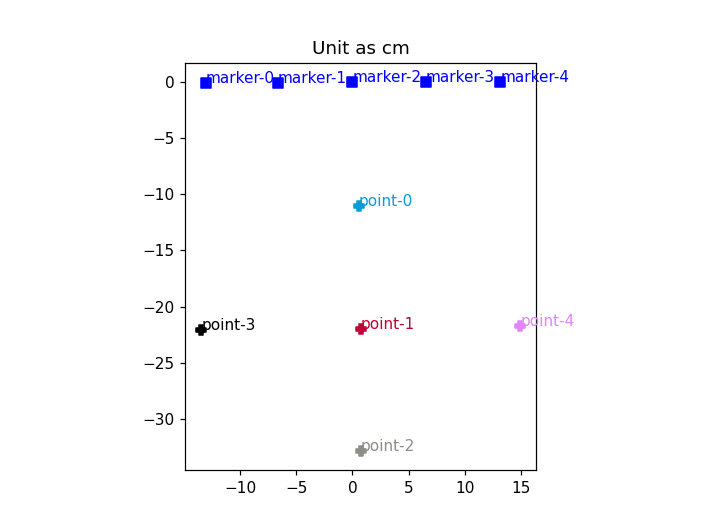

=> marker locations: 
[[-13.04, -0.11], [-6.64, -0.11], [0.0, 0.0], [6.52, -0.06], [13.16, 0.0]]
=> gt locations: 
[[0.59, -11.01], [0.72, -22.03], [0.77, -32.89], [-13.45, -22.05], [14.93, -21.77]]
distance from target to center marker:  [11.02458186 22.03740322 32.89649005 25.82853249 26.39830392]


In [8]:
### Plot the arrangement

plot_marker_inds = []

plt.figure()
plt.title('Unit as cm')
for i, mxy in enumerate(marker_locations):
    label='marker-{}'.format(i)
    m_color = 'blue'
    
    if i in plot_marker_inds:
        plt.scatter([mxy[0]], mxy[1], color='blue', label=label, marker='s')
        plt.text(mxy[0], mxy[1], s=label, color='blue')
    else:
        
        plt.scatter([mxy[0]], mxy[1], color=m_color, label=label, marker='s')
        plt.text(mxy[0], mxy[1], s=label, color=m_color)

for i, txy in enumerate(gt_loc_list):
    
    if name_list is not None and i < len(name_list):
        label = name_list[i]
    else:
        label = 'knock-{}'.format(i)
    
    label = 'point-{}'.format(i)
    
    plt.scatter([txy[0]], [txy[1]], color=color_mapping[i], label=label, marker='P')
    plt.text(txy[0], txy[1], s=label, color=color_mapping[i])
    

ax = plt.gca()
ax.set_aspect('equal')
  
plt.show()

# plt.ylim([-15, 8])
# plt.xlim([-28, 28])

print('=> marker locations: ')
print(np.round(marker_locations, 2).tolist())
print('=> gt locations: ')
print(np.round(gt_loc_list, 2).tolist())


r_array = np.array(gt_loc_list)
r_array = np.sqrt(np.sum( (r_array ** 2), axis=-1))
print('distance from target to center marker: ', r_array)

# Visualize the signals

=> showing 2/3 repeat


<IPython.core.display.Javascript object>


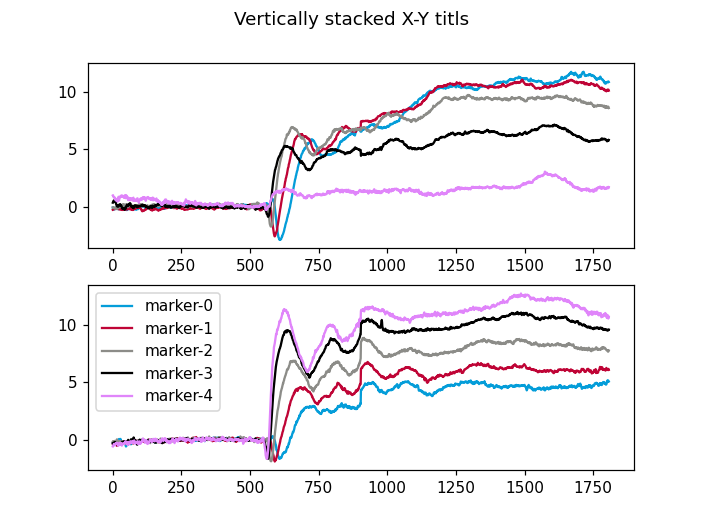

<IPython.core.display.Javascript object>


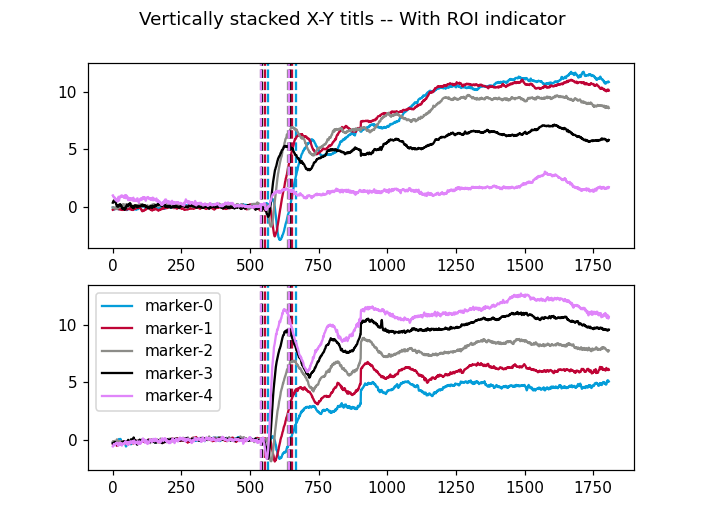

=> start frame for marker-0 is: 567
=> start frame for marker-1 is: 553
=> start frame for marker-2 is: 539
=> start frame for marker-3 is: 544
=> start frame for marker-4 is: 541


<IPython.core.display.Javascript object>


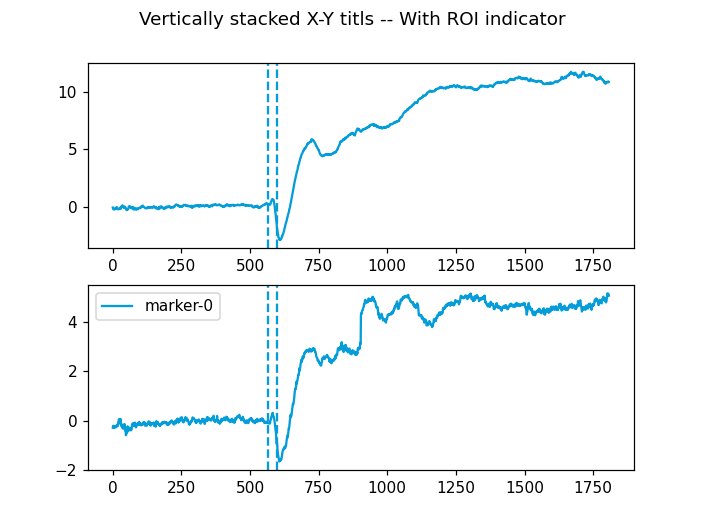

=> start frame for marker-0 is: 567


In [4]:
tgt_ind      = 2 # point index
exp_index    = 1 # at each target point, I repeat the knock 2-3 times, this index controls which repeat to load

# how many markers you want to show? 
marker_inds = [0,1,2,3,4]
m_location = [marker_locations[i] for i in marker_inds]

# mar_names = [marker_names[i] for i in marker_inds]
mar_names = ['marker-{}'.format(i) for i in marker_inds]

signal_list_list = []
for i in range(len(all_signal_list)):
    dist_ = (gt_loc_list[tgt_ind] - gt_locations_list[i]) ** 2
    
    dist_ = np.sum(dist_)
    if dist_ < 1e-1:
        signal_list_list.append([all_signal_list[i][m_ind] for m_ind in marker_inds])



# hyperparameter for detecting the arrival time of the transient waves using the thresholding algorithms 
#   as described in Eq(13) of the main paper
start_cfg = {
'std_coe': 20, 'smoothing_wsize':8, 'forward_window_size': 40,}

print("=> showing {}/{} repeat".format(exp_index + 1, len(signal_list_list)))        
signal_list = signal_list_list[exp_index]

pred_start_index_list = [
    signal_.get_start_index(**start_cfg) for signal_ in signal_list
                        ]

# plot the signal 
plot_signals(signal_list, label_list=mar_names, start_index_list=pred_start_index_list, window_size=100)

# plot only the measurement for marker index specified by 'show_ind'
show_ind = 0
plot_signals([signal_list[show_ind]], 
             start_index_list=[pred_start_index_list[show_ind]], if_double_plot=False)




# Localization through the backprojection

In [5]:
drawing_cfg=dict(
    name="weighted_cone",
    fov=6,
    thickness=-1,
    weighting_by_scale=False, #'log', #'sqrt'
    weighting_by_uncertainty=False,
    cone_weighting=0.04,
)


proj_theta_cfg=dict(
            std_coe=15.0,
            smoothing_wsize=8,
            forward_window_size=40,
            if_normalize=False,
            start_index=-1,           # use threshoulding to detect arrival time of waves automatically
            offset=20,
            window_size=120,
            stability_window_size=50, # not used 
            drawing_cfg=drawing_cfg,
            pre_size=10,
            safe_interval=10,
            weighting_cfg={'name': 'poly', 'params': [1.0]},  # Linear backprojection, no filtering
            global_start=False,
        )

# you might need to change the canvas size and position of marker_offset to position every items
#   in approperitae locations on the canvas

marker_scaling = 12 # scale the canvas size by 12. 

# whiteboard_corner = np.array([[-22, 22], [22, -2]])

proj_solver = BackProjSolver(m_location, marker_scaling=12, canvas_size=[700, 700], 
                             angle_mapping_obj=angle_mapping_obj, theta_cfg=proj_theta_cfg, 
                             corner_locations=None, marker_offset=[0, -200], marker_center=np.array([0, 0]))

    
save_path_ = os.path.join(dir_path, 'point:{}-exp:{}-pred.png'.format(tgt_ind, exp_index))


[0 0]
corner locations on canvas. tl. br
None


[565 552 538 542 540]


<IPython.core.display.Javascript object>


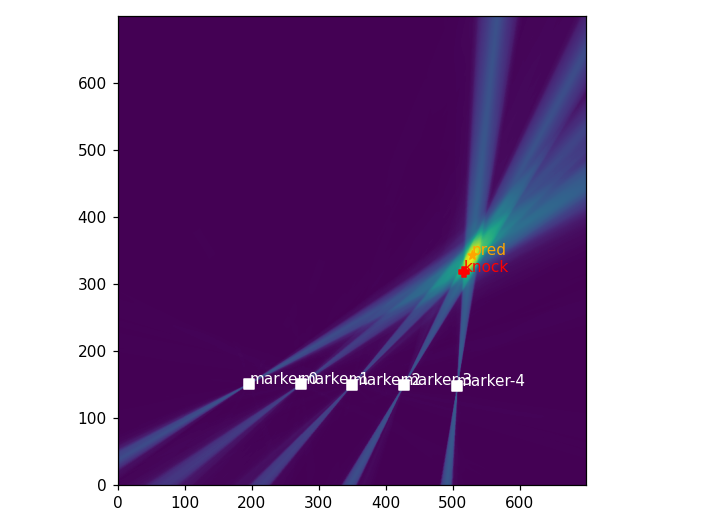

MSE: 2.33


In [6]:
# specify the starting time of the stable period by changing this variables 
hand_start_index_list = None # 
pred_xy, heat_map, plot_marker_locations, plot_pred_xy, img_gt_loc = proj_solver.pred_and_plot_polish(signal_list, gt_loc=gt_loc_list[tgt_ind], debug=True, 
                          start_index_list=hand_start_index_list ) 
plt.tight_layout()


gt_loc = gt_loc_list[tgt_ind]

mse = np.sqrt( ((gt_loc - pred_xy) ** 2).sum())
print('MSE: {:.2f}'.format(mse))


# Material Caliberation

This sections shows how to perform material and camera rotation caliberation. 

I recommend you to re-run the "Load data" section to load measurements from anisotropic materials, such as `data/birchlywood_anisotropy0.9`. This can be simply done by changing the `dir_path=data/birchlywood_anisotropy0.9/`

## Compute Stable ratios for all measurements

In [9]:
pred_func_name="soft_l1"
pred_func_cfg={}

# important hyper-params for estimating the stable ratio robustly
# you might want to tune the window_size, search range and std_coe a little bit
# the L1 curve fitting loss roughly indicates how well the caliberation goes
theta_cfg_ana = {'if_normalize': True, 'offset': 0, 'thre': -0.03, 
                 'angle_config': {'name': 'soft_l1_nobias'}, 
                 'std_coe': 20.0, 'smoothing_wsize':8, 'forward_window_size': 50,
                 'window_size': 70, 
                 'pre_size': 10, 'safe_interval': 10,   
                 "search_range": [30, 100, 2]}
    
save_marker_inds = [0,1,2,3,4]
# [point_ind][repeat_index][marker_index]
pred_tan_theta_list_list      = []
optimized_error_list_list     = []
flatten_error_list            = []

for pnt_ind in range(len(gt_loc_list)):  # point index

    signal_list_list = []
    for i in range(len(all_signal_list)):
        dist_ = (gt_loc_list[pnt_ind] - gt_locations_list[i]) ** 2

        dist_ = np.sum(dist_)
        if dist_ < 1e-1:
            signal_list_list.append(all_signal_list[i])
    
    
    pred_tan_theta_list = []
    error_list          = []
    
    if len(signal_list_list) == 0:
        pred_tan_theta_list_list.append(pred_tan_theta_list)
        optimized_error_list_list.append(error_list)
        continue
    
    for i, _signal_list in enumerate(signal_list_list):
        
        tmp_list       = []
        tmp_error_list = []
        for mind in save_marker_inds:
            _signal   = _signal_list[mind]
            ret       = _signal.get_theta(**theta_cfg_ana)
            pred_tan  = ret[0]
            min_error = ret[1][0]


            tmp_list.append(pred_tan)
            tmp_error_list.append(min_error)
            flatten_error_list.append(min_error)
        
        pred_tan_theta_list.append(tmp_list)
        error_list.append(tmp_error_list)
    
    pred_tan_theta_list_list.append(pred_tan_theta_list)
    optimized_error_list_list.append(error_list)

## Visualize the error distribution

<IPython.core.display.Javascript object>


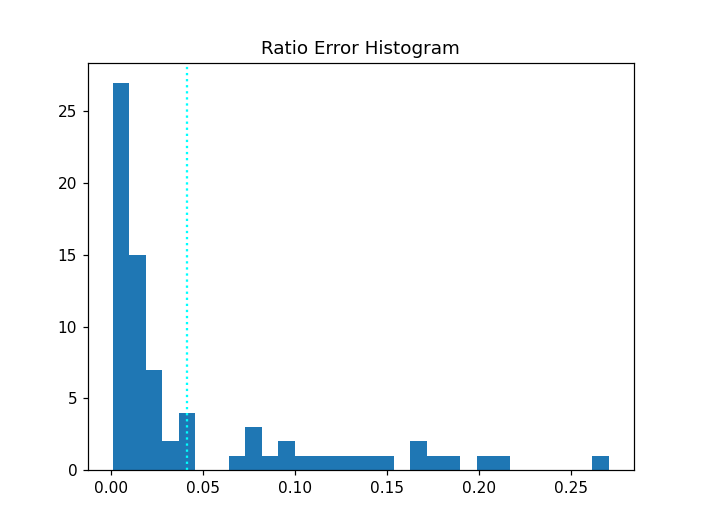

<IPython.core.display.Javascript object>


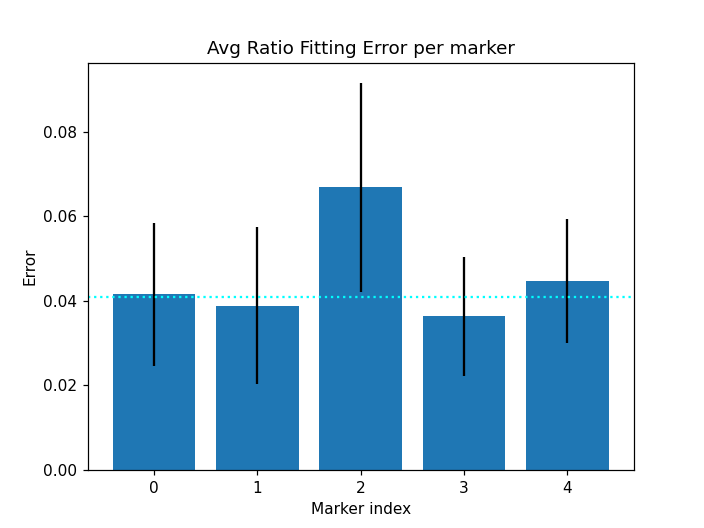

In [10]:
##### ------------- #####
# We visualize the error for fitting stable ratios over the stable periods
# since the computation invovles division, there might be some very large error
# noisy signals, or divid_zero signals will be filtered out later

##### ------------- #####


error_list_per_marker = [[], [], [], [], []]
for pnt_ind in range(len(pred_tan_theta_list_list)):
    for rep_ind in range(len(pred_tan_theta_list_list[pnt_ind])):
        for m_ind in range(5):
            error_list_per_marker[m_ind].append(optimized_error_list_list[pnt_ind][rep_ind][m_ind])

error_variance_per_mar = [np.std(np.array(_)) * 0.3 for _ in error_list_per_marker]  
error_list_per_marker = [np.array(_).mean() for _ in error_list_per_marker]            

# error threshould for removing noisy or divided-zero signals
ratio_error_thres = np.percentile(np.array(flatten_error_list), 70)

plt.figure()
plt.title('Ratio Error Histogram')
plt.hist(flatten_error_list, bins=30)

plt.axvline(x=ratio_error_thres, linestyle='dotted', color='cyan')
plt.show()



plt.figure()
plt.title('Avg Ratio Fitting Error per marker')
plt.xlabel('Marker index')
plt.ylabel('Error')
plt.bar(list(range(5)), error_list_per_marker, yerr=error_variance_per_mar)
plt.axhline(y=ratio_error_thres, linestyle='dotted', color='cyan')
plt.show()



## Preprocess for visualize ratios and caliberation

In [11]:
##### ------------- #####
# Preprocess the pre-computed stable ratios, 
# 1. add filtering
# 2. pair the (computed_stable_ratio,  tan(angle of arrival))

##### ------------- #####

def unfold_list_of_array(array_list, reduction=None):
    """
    Args:
        array_list: List[np.ndarray].  length may vary
        reduction: in ['mean', None]
    """
    
    ret_list = [] 
    num_array = len(array_list)

    for i in range(num_array):
        tmp_array = array_list[i]
        
        if len(tmp_array) < 1:
            continue
        
        if reduction == 'mean':
            ret_list.append(np.mean(tmp_array))
        elif reduction == None:
            ret_list += tmp_array.tolist()
    
    return ret_list
        
        
use_hand_theta = 0
if use_hand_theta:

    for i in range(len(pred_tan_theta_list_list_hand)):
        pred_list = pred_tan_theta_list_list_hand[i]
        for rep_ind in range(len(pred_list)):
            for m_ind in range(len(pred_list[rep_ind])):
                pred_tan_theta_list_list[i][rep_ind][m_ind] = pred_tan_theta_list_list_hand[i][rep_ind][m_ind] 

plot_marker_ind_list = [0, 1,2,3,4]

plot_tgt_ind_list = list(range(len(pred_tan_theta_list_list))) # I remove 4
# plot_tgt_ind_list = [0,1,2,3,4,5, 6, 7] # I remove 4

plot_pred_tan_list = []
plot_gt_tan_list = []
plot_gt_theta_list = []
plot_m_ind_list = [] # used to identify different scaling for different marker

do_average = True
filtering_by_error_thres = True

remove_small_sample = False

reduction = None
if do_average:
    reduction = 'mean'

for pnt_ind in plot_tgt_ind_list:
    if not (i in [0,1,2,3,4,5,6,7]):
            pass
    # if not (pnt_ind in [7, 8]):
    #     continue
    
    # for five markers
    rep_pred_list = [[], [], [], [], []]
    rep_gt_tan_list = [[], [], [], [], []]
    rep_gt_theta_list = [[], [], [], [], []]
    rep_marker_ind_list = [[], [], [], [], []]
    
    if remove_small_sample:
        if len(pred_tan_theta_list_list[pnt_ind]) < 2:
            continue
    for rep_ind in range(len(pred_tan_theta_list_list[pnt_ind])):
        
        for m_ind in plot_marker_ind_list:
            if len(pred_tan_theta_list_list[pnt_ind][rep_ind]) == 0:
                continue
            ratio_error = optimized_error_list_list[pnt_ind][rep_ind][m_ind]
            pred_tan = pred_tan_theta_list_list[pnt_ind][rep_ind][m_ind]
            
            if filtering_by_error_thres and ratio_error > ratio_error_thres:
                # print('remove measurement with large ratio error')
                continue
            
            if (np.isnan(pred_tan)):
                print('nan encountered')
                continue
            
            if pred_tan is None or (np.abs(pred_tan) > 8):
                # print(gt_tan_list[pnt_ind][m_ind], pred_tan, pnt_ind, m_ind)
                continue
            if pred_tan is None or (gt_tan_list[pnt_ind][m_ind] < -1.5):
                # print(gt_tan_list[pnt_ind][m_ind], pred_tan, pnt_ind, m_ind)
                pass
            if np.abs(gt_tan_list[pnt_ind][m_ind]) > 5:
                # print(gt_tan_list[pnt_ind][m_ind], pnt_ind, m_ind)
                continue

            rep_pred_list[m_ind].append(pred_tan)

            rep_gt_tan_list[m_ind].append(gt_tan_list[pnt_ind][m_ind])

            # plot_gt_theta_list.append( np.rad2deg(point_angle_list_list[pnt_ind][m_ind]))
            rep_gt_theta_list[m_ind].append( point_angle_list_list[pnt_ind][m_ind])
            
            rep_marker_ind_list[m_ind].append(m_ind)
    
    rep_pred = [np.array(_) for _ in rep_pred_list]
    rep_gt_tan = [np.array(_) for _ in rep_gt_tan_list]
    rep_gt_theta = [np.array(_) for _ in rep_gt_theta_list]
    rep_marker_ind = [np.array(_, dtype=np.int32) for _ in rep_marker_ind_list]
    
    rep_pred = unfold_list_of_array(rep_pred, reduction)
    rep_gt_tan = unfold_list_of_array(rep_gt_tan, reduction)
    rep_gt_theta = unfold_list_of_array(rep_gt_theta, reduction)
    rep_marker_ind = unfold_list_of_array(rep_marker_ind, reduction)
    rep_marker_ind = [int(_) for _ in rep_marker_ind]
        
    plot_pred_tan_list += rep_pred
    plot_gt_tan_list += rep_gt_tan
    plot_gt_theta_list += rep_gt_theta
    plot_m_ind_list  += rep_marker_ind
# print(plot_gt_tan_list, plot_pred_tan_list)
print(len(plot_gt_tan_list), len(plot_pred_tan_list))
# print(plot_gt_tan_list, plot_pred_tan_list)
plot_color_list = [color_mapping[i] for i in plot_m_ind_list]

16 16


## Material anisotropy caliberation 

<IPython.core.display.Javascript object>


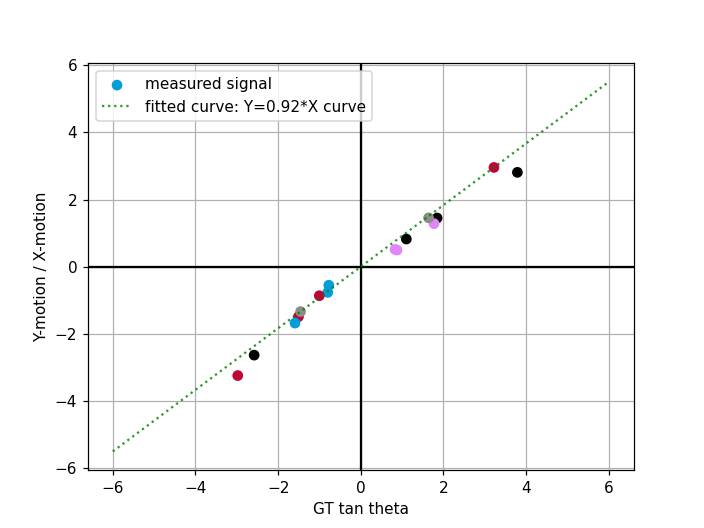

Optimization terminated successfully.
         Current function value: 0.232073
         Iterations: 26
         Function evaluations: 52
=>  The slope of the fitted curve (material anisotropy): 0.918
=>  L1 loss of the fitted curve: 0.213


In [12]:
##### ------------- #####
# plot the paired (computed_stable_ratio,  tan(angle of arrival))
# plot the best-fitted-line.  the slope of this line is the material anisotropy

##### ------------- #####

from scipy.optimize import least_squares, minimize
plt.figure()
plt.xlabel('GT tan theta')
plt.ylabel('Y-motion / X-motion')
# plt.xlim([0, 2])
# plt.ylim([0, 2])

# plt.ylim([-16, 16])

ax = plt.gca() #
# ax.set_aspect('equal')

plt.grid(True, which='both')

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.scatter(plot_gt_tan_list, plot_pred_tan_list, label='measured signal', color=plot_color_list)

scale_median = np.median( np.array(plot_pred_tan_list) / np.array(plot_gt_tan_list))




mse = np.array(plot_gt_tan_list) - np.array(plot_pred_tan_list)

def linear_scaling_cost(param, pred_list, gt_list):
    k = param[0]
    
    loss = np.abs(pred_list / k - gt_list).mean()
    return loss
    
linear_params = np.array([1.0])

linear_res = minimize(linear_scaling_cost, linear_params,  method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True}, 
        args=(np.array(plot_pred_tan_list), np.array(plot_gt_tan_list)),
              bounds=[[-20, 40.0]])



scale_ = linear_res.x[0]
linear_x = np.linspace(-6, 6, 10)
linear_y = linear_x * scale_
plt.plot(linear_x, linear_y, color='green', alpha=0.8, linestyle='dotted', label='fitted curve: Y={:.2f}*X curve'.format(scale_))

# plt.scatter(np.array(plot_gt_tan_list) * -1.0, np.array( plot_pred_tan_list) * -1.0, alpha=0.5, label='symmetry across 0')
plt.legend()
plt.show()

scaled_mse = np.array(plot_gt_tan_list) * linear_res.x[0] - (np.array(plot_pred_tan_list))
print('=>  The slope of the fitted curve (material anisotropy): {:.3f}'.format(linear_res.x[0]))

print('=>  L1 loss of the fitted curve: {:.3f}'.format(np.abs(scaled_mse).mean() ))


## Materail anisotropy and camera rotation caliberation

In the first section of the supplmentary materials, we mentioned that there might be misalignment between the object plane axis and camera frame axis, and we introduced one extra rotation parameter $\alpha$ in Eq. (17) of the supplementary to account for that.  We also mentioned in Eq. (25), that this rotation parameter and material anisotropy can be caliberated jointly. 


16 16
         Current function value: 0.119239
         Iterations: 5
         Function evaluations: 204
         Gradient evaluations: 64
=> Done caliberating. 
=> The material anisotropy: 0.88 ---- the rotation parameter: -0.0465


/home/tyzhang/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:566: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/tmp/ipykernel_2430089/1791768491.py:41: OptimizeWarning: Unknown solver options: xatol
  res = minimize(curve_cost_rotation, params,  method='BFGS',


<IPython.core.display.Javascript object>


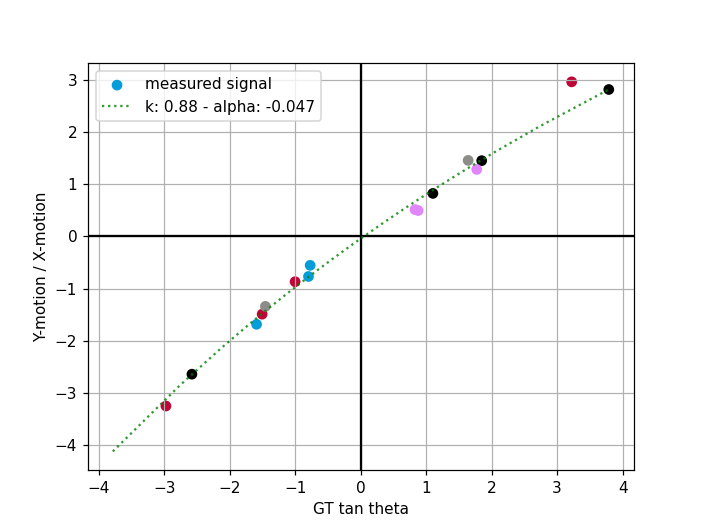

=> L1 loss of the fitted curve: 0.119


In [13]:
# plot_pred_tan_list
# plot_gt_theta_list
from scipy.optimize import least_squares, minimize


def target_function_rotation(theta, param=[1.0, 0.0]):
    
    k = param[0]
    alpha = param[1]
    
    derived_tan_theta = np.tan(theta + alpha) * k
    
    return derived_tan_theta
    

def curve_cost_rotation(param, dummy_gt_theta_list, pred_tan_list):
    
    k = param[0]
    alpha = param[1]
    
    cost_list = []
    for d_theta, pred_tan in zip(dummy_gt_theta_list, pred_tan_list):
        
        right = np.tan(d_theta + alpha) * k
        
        
        cost_ = np.abs(pred_tan - right)
        
        cost_list.append(np.abs(cost_))
    cost_array = np.array(cost_list)
    cost_array = np.clip(cost_array, a_min=0, a_max=5)
    loss = np.mean(cost_array)
    
    return loss


print(len(plot_pred_tan_list), len(plot_gt_theta_list))

params = np.array([1.0, 0.0])
# nelder-mead, trust-krylov,  BFGS
res = minimize(curve_cost_rotation, params,  method='BFGS', 
               options={'xatol': 1e-7, 'disp': True}, 
        args=(np.array(plot_gt_theta_list), np.array(plot_pred_tan_list)),
              bounds=[[-10, 10.0], [-2.0, 2.0]])
              # bounds=[[-10, 10.0], [-0.2, 0.2]])

new_gt_ratio_list = np.array([target_function_rotation(g_theta, res.x) for g_theta in plot_gt_theta_list])
l1_error = new_gt_ratio_list - plot_pred_tan_list
mean_l1 = np.abs(l1_error).mean()

print("=> Done caliberating. ")
print("=> The material anisotropy: {:.2f} ---- the rotation parameter: {:.4f}".format(res.x[0], res.x[1]))


# ------------------------------ # 
# caliberation finished.         #
# Visualize the results below    #
# ------------------------------ # 



optimized_params = res.x
# optimized_params = [1.0, -0.42]
scaling, alpha = optimized_params

from scipy.optimize import least_squares, minimize
plt.figure()
plt.xlabel('GT tan theta')
plt.ylabel('Y-motion / X-motion')
# plt.xlim([0, 2])
# plt.ylim([0, 2])

# plt.ylim([-16, 16])

ax = plt.gca() #
# ax.set_aspect('equal')

plt.grid(True, which='both')

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.scatter(plot_gt_tan_list, plot_pred_tan_list, label='measured signal', color=plot_color_list)


theta_lim = np.arctan(np.max(np.abs(plot_gt_tan_list)))
linear_theta = np.linspace(-1.0 * theta_lim, theta_lim, 30)
linear_x = np.tan(linear_theta)
rotation_y = [target_function_rotation(_t, optimized_params) for _t in linear_theta]

plt.plot(linear_x, rotation_y, color='green', alpha=0.8, linestyle='dotted', 
         label='k: {:.2f} - alpha: {:.3f}'.format(res.x[0], res.x[1]))

plt.legend()
plt.show()


print('=> L1 loss of the fitted curve: {:.3f}'.format(mean_l1))
